# TensorFlow Tutorial #19
# 超参数优化

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)/[GitHub中文](https://github.com/Hvass-Labs/TensorFlow-Tutorials-Chinese)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

中文翻译[ZhouGeorge](https://github.com/ZhouGeorge)

## 介绍

在利用Tensorflow构筑和训练神经网络时你有很多参数需要选择。它们通常被成为超参数Hyper-Parameters。比如，神经网络有多少层是一个超参数，一个层里有多少个节点是另一个超参数，我们选取什么激活函数也是一个超参数，等等。优化方法中也有许多超参数需要选择，例如学习率。

一个搜索好的超参数的方法是手动微调，你设置一个参数然后看它的表现，然后你再修改另一个参数看性能是否提高了。你试着建立一种直觉，关于哪些工作有效并据此指导你的参数搜索。这不仅对人类研究者来说是非常耗时的，而且最优的参数通常与人类的直觉相反，你不会发现它们！

另一个搜索好的超参数的方法是将每个参数的有效范围划分为均匀间隔的值，然后让计算机尝试所有参数值的组合。这被称为网格搜索（ Grid Search）。尽管它全部由计算机执行，它变的相当耗时因为当你增加更多的超参数时，参数组合的数量是指数级增加的。这个问题被称为维度灾难。举一个例子，你有4个超参数需要调整，每个参数有10个有效值，它们一共有10^4个组合。如果你再增加一个超参数，那么组合的数量将达到10^5个。

还有一个搜索好的超参数的方法是随机搜索。代替系统地尝试每一种网络搜索中的超参数组合，现在我们随机地尝试一些参数组合。这就像大海捞针一样，并且当超参数增加时，通过随机采样的方式找到合适的超参数组和的可能性会降到0.

这个教程中用了一聪明的方法去找好的超参数，即贝叶斯优化。你需要熟悉Tensorflow，Keras和卷积神经网络，参见教程 #01, #02和 #03-C。

## 流程图


超参数优化的问题在于评估一组参数的性能开销相当大。因为我们首先要建立相应的神经网络，然后我们还要训练它，最后我们还要在测试集上测试它的性能。在这个教程中，我们用MNIST数据，所以训练可以被很快地完成，但是如果在更复杂的问题上即使用一台非常快的电脑训练可能需要花费几小时，几点天或甚至是几周。所以我们需要一个优化方法使超参数的搜索尽可能有效，只有在绝对必要的时候才评估模型实际的性能。

贝叶斯优化的想法是构建另一个模型关于超参数的搜索空间。有一种模型被称为高斯处理。它给我们提供了一个关于性能是如何随超参数变化而变化的估计。当我们评估一组超参数的真实性能时，我们知道它的性能是什么-除了一些噪音。我们可以通过贝叶斯优化器得到在搜索空间中关于超参数选择的新的建议，它可能是我们还没有探索过的，或者是贝叶斯优化器认为这个超参数可以带来很大的提升。然后我们重复这个过程多次，直到贝叶斯优化器建立好关于性能是如何随超参数变变化的模型，那么我们就可以选出最好的参数。

算法的流程图大致如下：

![Flowchart](images/19_flowchart_bayesian_optimization.png)

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

/home/magnus/anaconda3/envs/tf-test/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


我们需要引如Keras的一些模块。

In [2]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import load_model

**注意：** 我们用Keras保存和加载模型，所以你必须安装 [h5py](http://docs.h5py.org/en/latest/build.html#install)。你也必须安装 [scikit-optimize](https://scikit-optimize.github.io/)用于超参数的优化。

您应该能够在终端中运行下列命令来安装它们：

`pip install h5py scikit-optimize`

**注意：** 这个笔记本需要 `scikit-optimize`中的绘制函数，而在撰写本文时，它还没有被合并到官方版本中。如果这个笔记本不能通过上面的指令安装 `scikit-optimize`的版本，你可能需要通过运行以下命令从开发分支中来安装指定的`scikit-optimize`版本 ：
`pip install git+git://github.com/Hvass-Labs/scikit-optimize.git@dd7433da068b5a2509ef4ea4e5195458393e6555`

In [3]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

开发环境Python3.6以及各个包的版本：

In [4]:
tf.__version__

'1.4.0'

In [5]:
tf.keras.__version__

'2.0.8-tf'

In [6]:
skopt.__version__

'0.4'

## 超参数

在本教程中，我们希望找到一个超参数，它使一个简单的卷积神经网络在为手写的数字进行分类时表现得最好。

对于这个示范，我们想要找到以下超参数：

* 优化器的学习率。
* 全连接层的数目。
* 全连接层的节点数目。
* 在所有层中‘sigmoid’还是‘relu’激活函数的选择。

我们将用Python的包`scikit-optimize` (or `skopt`)来找到这些超参数的最好的选择。在我们开始搜索超参数之前，我们首先需要为这些超参数定义有效的搜索范围或者搜索维度。

下面是学习率的收缩维度。它是一个实数（浮点），下界是`1e-6`，上界是`1e-2`。但是，我们用了对数变换来代替直接在这两个边界中搜索，所以我们从搜索数字`k`到搜索`1ek`，这样边界就变成了-6和-2。这比搜索整个指数范围要好。

In [7]:
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learning_rate')

下面是神经网络全连接层数目的搜索维度。这是一个整数，在这个网络中我们希望至少有1个全连接层，最多有5个全连接层

In [8]:
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')

下面是每个全连接层节点数目的搜索维度，它也是一个整数并且我们希望在这个网络中它最少有5个节点，最大是512个节点。

In [9]:
dim_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')

下面是激活函数的搜索维度。这是一个组合或分类参数，可以是“relu”或“sigmoid”。

In [10]:
dim_activation = Categorical(categories=['relu', 'sigmoid'],
                             name='activation')

然后我们将所有这些搜索维度合并到一个列表中。

In [11]:
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]

用我们通过手工调优找到的一个不错的选择来开始搜索超参数是很有帮助的。但是我们将使用以下参数，这些参数表现得不太好是为了更好地展示超参数优化的有用性：学习率1e-5，单个16个节点的全连接层和relu激活函数

注意这些超参数被打包到一个列表中。这就是“skopt”在内部对超参数的工作方式。因此，您需要确保维度的顺序与上面“维度”中给出的顺序一致。

In [12]:
default_parameters = [1e-5, 1, 16, 'relu']

### log-dir-name 辅助函数

我们将记录所有参数组合的训练过程，它们可以用TensorBoard可视化并比较。这些可以通过设置一个公共的上级地址，然后对应每组超参数创建恰当名字的子地址来完成。


In [13]:
def log_dir_name(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):

    # The dir-name for the TensorBoard log-dir.
    s = "./19_logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate,
                       num_dense_layers,
                       num_dense_nodes,
                       activation)

    return log_dir

## 加载数据

MNIST数据集大约12MB，如果没在文件夹中找到就会自动下载。

In [14]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


现在已经载入了MNIST数据集，它由70,000张图像和对应的标签（比如图像的类别）组成。数据集分成三份互相独立的子集。

In [15]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


类型标签使用One-Hot编码，这意外每个标签是长为10的向量，除了一个元素之外，其他的都为零。这个元素的索引就是类别的数字，即相应图片中画的数字。我们也需要测试数据集类别数字的整型值，用下面的方法来计算。

In [16]:
data.test.cls = np.argmax(data.test.labels, axis=1)

我们将验证集中的性能作为一个指示（选择在之前没有见过的数据上表现的最好的超参数）。

Keras API验证集要是一个元组。

In [17]:
validation_data = (data.validation.images, data.validation.labels)

## 数据维度

在下面的源码中，有很多地方用到了数据维度。它们只在一个地方定义，因此我们可以在代码中使用这些数字而不是直接写数字。

In [18]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
# This is used for plotting the images.
img_shape = (img_size, img_size)

# Tuple with height, width and depth used to reshape arrays.
# This is used for reshaping in Keras.
img_shape_full = (img_size, img_size, 1)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### 用来绘制图片的帮助函数

这个函数用来在3x3的栅格中画9张图像，然后在每张图像下面写出真实类别和预测类别。

In [19]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 绘制几张图像来看看数据是否正确

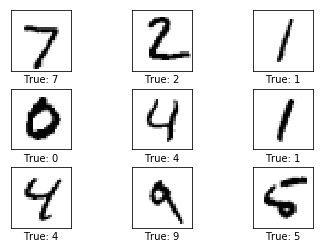

In [20]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

###  绘制错误案例的辅助函数

用于绘制测试集中图像被错误分类的案例。

In [21]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != data.test.cls)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

## 超参数优化

完成超参数优化需要完成几个步骤。

### 创建模型

我们首先需要一个函数取一组超参数并且用这些参数创建对应的卷积神经网络。

我们用Keras搭建神经网络，更多细节参见教程 #03-C。

In [22]:
def create_model(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """
    
    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Add an input layer which is similar to a feed_dict in TensorFlow.
    # Note that the input-shape must be a tuple containing the image-size.
    model.add(InputLayer(input_shape=(img_size_flat,)))

    # The input from MNIST is a flattened array with 784 elements,
    # but the convolutional layers expect images with shape (28, 28, 1)
    model.add(Reshape(img_shape_full))

    # First convolutional layer.
    # There are many hyper-parameters in this layer, but we only
    # want to optimize the activation-function in this example.
    model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                     activation=activation, name='layer_conv1'))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Again, we only want to optimize the activation-function here.
    model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                     activation=activation, name='layer_conv2'))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected / dense layer.
    model.add(Flatten())

    # Add fully-connected / dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    for i in range(num_dense_layers):
        # Name of the layer. This is not really necessary
        # because Keras should give them unique names.
        name = 'layer_dense_{0}'.format(i+1)

        # Add the dense / fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        name=name))

    # Last fully-connected / dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(num_classes, activation='softmax'))
    
    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(lr=learning_rate)
    
    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

### 训练和评估模型

具有最优参数的神经网络被保存到硬盘中，它在之后可以被加载。下面是模型的文件名。

In [23]:
path_best_model = '19_best_model.keras'

这是保存到磁盘的模型的分类精度。这是全局变量，会随着超参数的优化而进行更新。

In [24]:
best_accuracy = 0.0

这个函数是用于在给定超参数下创建并训练神经网络，然后在验证集上评估它的性能。然后这个函数返回所谓的适当值（又名：客观值），是在验证集上的负分类精度。这是负值，因为`skopt`通过执行最小化而不是最大化。

注意函数修饰符`@use_named_args`，包装了fitness函数，所以它能通过一个是列表的参数被调用，比如`fitness(x=[1e-4, 3, 256, 'relu'])`。这是`skopt`内部的调用样式。

In [25]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,
            num_dense_nodes, activation):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation)

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, num_dense_layers,
                           num_dense_nodes, activation)
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        batch_size=32,
        write_graph=True,
        write_grads=False,
        write_images=False)
   
    # Use Keras to train the model.
    history = model.fit(x=data.train.images,
                        y=data.train.labels,
                        epochs=3,
                        batch_size=128,
                        validation_data=validation_data,
                        callbacks=[callback_log])

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_acc'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy

### 试运行

在我们运行超参数优化之前，让我们先检查当传入默认的超参数时上面的函数是否有效。

In [26]:
fitness(x=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Train on 55000 samples, validate on 5000 samples
Epoch 1/3
55000/55000 [==============================] - 3s - loss: 2.2525 - acc: 0.1995 - val_loss: 2.1754 - val_acc: 0.3578
Epoch 2/3
55000/55000 [==============================] - 2s - loss: 2.0279 - acc: 0.4612 - val_loss: 1.8432 - val_acc: 0.5558
Epoch 3/3
55000/55000 [==============================] - 4s - loss: 1.6227 - acc: 0.5998 - val_loss: 1.3877 - val_acc: 0.6654

Accuracy: 66.54%



-0.66539999999999999

### 运行超参数优化

现在我们已经准备好运行scikit-optimize中的贝叶斯优化来优化真实的超参数。注意，先要用我们通过手工调优发现`default_parameters`来调用`fitness()`作为开始，这将帮助优化器更快地找到更好的超参数。

这里有很多的参数可以进行实验，包括调用`fitness()`函数的次数，这里我们设置成40。但是 `fitness()`的评估花销是很大的，所以不应该运行太多次，特别是很大的网络结构和数据集

你也可以实验贝叶斯优化器的内部模型的不同的采集函数，它决定了如何找到一组新的超参数 。
或者你也可以尝试用另一种贝叶斯优化器，比如随机森林。

In [27]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=40,
                            x0=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Train on 55000 samples, validate on 5000 samples
Epoch 1/3
55000/55000 [==============================] - 2s - loss: 2.2287 - acc: 0.1868 - val_loss: 2.1264 - val_acc: 0.3182
Epoch 2/3
55000/55000 [==============================] - 2s - loss: 1.9607 - acc: 0.4438 - val_loss: 1.7713 - val_acc: 0.5082
Epoch 3/3
55000/55000 [==============================] - 5s - loss: 1.5763 - acc: 0.5579 - val_loss: 1.3832 - val_acc: 0.6166

Accuracy: 61.66%

learning rate: 6.1e-04
num_dense_layers: 2
num_dense_nodes: 474
activation: sigmoid

Train on 55000 samples, validate on 5000 samples
Epoch 1/3
55000/55000 [==============================] - 3s - loss: 1.3354 - acc: 0.5258 - val_loss: 0.3002 - val_acc: 0.9112
Epoch 2/3
55000/55000 [==============================] - 4s - loss: 0.2336 - acc: 0.9269 - val_loss: 0.1626 - val_acc: 0.9538
Epoch 3/3
55000/55000 [==============================] - 7s - loss: 0.1403 - acc: 0.956

### 优化过程

超参数的优化过程可以被很容易的画出。最佳的适度值是在y轴上绘制的，记住这是验证集上负分类精度。

注意在发现实质性改进之前必须尝试很少的超参数。

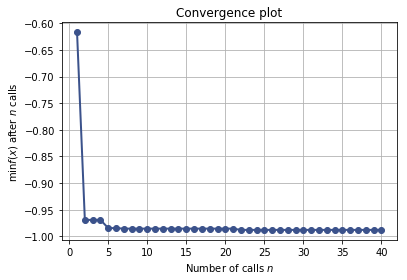

In [28]:
plot_convergence(search_result)

### 最优超参数

贝叶斯优化器所发现的最好的超参数被打包成一个列表，因为这是它在内部使用的。

In [29]:
search_result.x

[0.0023584457378584664, 4, 144, 'relu']

我们可以转换这些参数到一个在搜索空间维度中专有名称的地址

首先，我们需要对搜索空间对象的引用。

In [30]:
space = search_result.space

然后我们可以用它创建一个地址，超参数在搜索空间维度里具有的专有的名称。

In [31]:
space.point_to_dict(search_result.x)

{'activation': 'relu',
 'learning_rate': 0.0023584457378584664,
 'num_dense_layers': 4,
 'num_dense_nodes': 144}

下面这些超参数对应的适度值。这是一个负值，因为贝叶斯优化器执行最小化，所以我们不得不将分类进度最大化问题取反。

In [32]:
search_result.fun

-0.98799999999999999

我们也看到所有被贝叶斯优化器尝试过的超参数和它们对应的适度值（负的分类精度）。对它们进行排序，以便首先显示最高的分类准确度。

看起来’relu‘激活总的表现要比’sigmoid‘好。我们需要画出这些结果，否则，很难看出哪种参数选择模式是好的。

In [33]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-0.98799999999999999, [0.00057102338020535671, 1, 246, 'relu']),
 (-0.98799999999999999, [0.0023584457378584664, 4, 144, 'relu']),
 (-0.98699999999999999, [0.0043924439217142824, 3, 311, 'relu']),
 (-0.98680000000000001, [0.00025070302453255417, 2, 435, 'relu']),
 (-0.98640000000000005, [0.0020904801989242469, 5, 436, 'relu']),
 (-0.98560000000000003, [0.00017567744133971055, 4, 453, 'relu']),
 (-0.98560000000000003, [0.00018871091218374878, 3, 441, 'relu']),
 (-0.98560000000000003, [0.0010013922052631494, 3, 496, 'relu']),
 (-0.98519999999999996, [0.006752254693985822, 2, 105, 'relu']),
 (-0.98499999999999999, [0.0001905308801138268, 4, 418, 'relu']),
 (-0.98460000000000003, [0.0073224617473678331, 3, 166, 'relu']),
 (-0.98440000000000005, [0.0020143982003767271, 4, 512, 'relu']),
 (-0.98419999999999996, [0.0014193250864683331, 2, 62, 'relu']),
 (-0.97960000000000003, [0.00023735076383216567, 1, 164, 'relu']),
 (-0.97860000000000003, [0.0026064900033469073, 1, 126, 'sigmoid']),
 (-0

### 绘制

在`skopt`里有一些可利用的绘制函数。举个例子，我们可以画出`activation`参数的直方图，它显示了在超参数优化期间样本的分布。

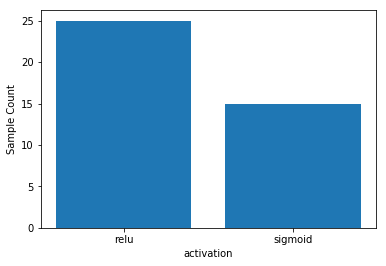

In [34]:
fig, ax = plot_histogram(result=search_result,
                         dimension_name='activation')

我们也可以制作一个landscape-plot是关于显示二个维度搜索空间上估计的适度值，这里采用`learning_rate`和`num_dense_layers`两个变量。

贝叶斯优化器的工作原理是建立一个搜索空间的代理模型，然后搜索这个模型而不是真正的搜索空间，因为这样更快。这个图展示了贝叶斯优化器构建的最后一个代理模型，黄色区域比较好，蓝色区域比较糟。黑点显示了优化器对搜索空间的采样，而红星显示了最佳参数。

这里应该注意几点。首先，这种搜索空间的代理模型可能不准确。它仅通过调用`fitness（）`函数的40个样本构建，用于训练具有给定超参数选择的神经网络。模拟的landscape可能与它的真实值有很大的不同，尤其是在大搜索空间的区域取很少的样本情况下。其次，由于在神经网络的训练过程中随机产生的噪声，所以每次运行超参数优化时，情况可能会发生变化。第三，这副图显示了改变2个参数`num_dense_layers`和 `learning_rate` 的效果，这也称为部分依赖图，是一种仅在二维中可视化高维空间的方法。

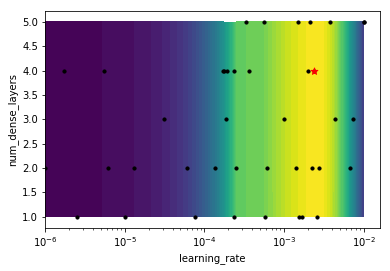

In [35]:
fig = plot_objective_2D(result=search_result,
                        dimension_name1='learning_rate',
                        dimension_name2='num_dense_layers',
                        levels=50)

我们不能制作一个landscape关于 `activation`超参数的图，因为它是一个分类变量可以是两个字符串中的一个`relu` 或 `sigmoid`。如何编码取决于贝叶斯优化器，例如，它是使用高斯过程还是随机的森林。但是目前还不能使用`skopt`的内置函数来绘制。

相反，我们只想使用我们通过名称识别搜索空间的实数和整数值维度。

In [36]:
dim_names = ['learning_rate', 'num_dense_nodes', 'num_dense_layers']

然后我们可以对这些维度的所有组合做一个模型图。

对角线上的图上显示了单个维度对适度值的影响。这是一个所谓的部分依赖图。它显示了近似的适度值随着那个维度的值的变化而变化。

在对角线下方的图显示2个维度的部分依赖图。这显示了当我们同时改变两个维度时，近似的适度值是如何变化的。

这些部分依赖图只是模型的适应性函数的近似值-只是对真正的适应性函数 `fitness()`的近似。这里可能有一点难理解。举个例子，部分依赖是通过固定“学习速率”一个值来计算的，然后在搜索空间中为剩余的维度取大量的随机样本。然后对所有这些点的估计适度值进行平均。然后，对`learning_rate`的其他值重复该过程，以显示它如何影响平均的适度值。两个维度的部分依赖图的处理也是相同的。

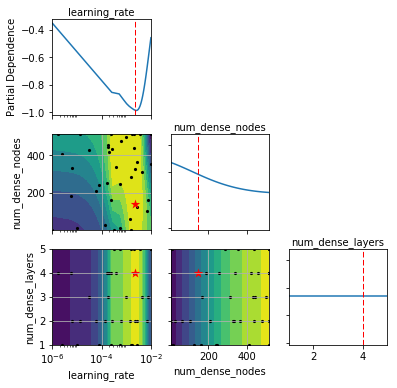

In [37]:
fig, ax = plot_objective(result=search_result, dimension_names=dim_names)

我们也可以用另一种模型图。这里对角线上显示贝叶斯优化器的每次超参数的采样分布的直方图。直方图下面的图显示在搜索空间中采样的位置，颜色编码显示了采样的顺序。对于大量的采样你希望看到这些样本最终集中在搜索空间的某个区域。

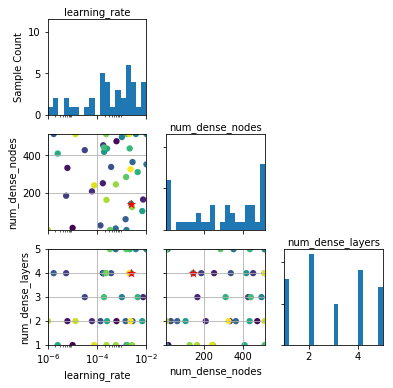

In [38]:
fig, ax = plot_evaluations(result=search_result, dimension_names=dim_names)

### 在测试集上评估最优的模型

你现在可以将最优模型用在测试集上。用Keras重再模型非常方便。

In [39]:
model = load_model(path_best_model)

之后我们在测试集上评价模型的性能。

In [40]:
result = model.evaluate(x=data.test.images,
                        y=data.test.labels)

 8960/10000 [=========================>....] - ETA: 0s

我们可以输出测试集的所有性能指标。

In [41]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.0363312054525
acc 0.9888


或者我们可以打印分类准确率。

In [42]:
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

acc: 98.88%


### 预测新的数据

我们也可以预测新图像的分类。我们从测试集取一些图像，你可以加载自己的图形到numpy数组来代替。

In [43]:
images = data.test.images[0:9]

下面是这些图像正确类别数。只在画图的时候用到。

In [44]:
cls_true = data.test.cls[0:9]

获得预测结果的独热编码数组。

In [45]:
y_pred = model.predict(x=images)

将结果转换成整形。

In [46]:
cls_pred = np.argmax(y_pred,axis=1)

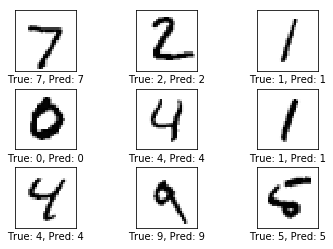

In [47]:
plot_images(images=images,
            cls_true=cls_true,
            cls_pred=cls_pred)

### 画出错误分类的例子

我们画出测试集中被错误分类图像的例子。

首先我们获得测试集中所有图像的预测结果。

In [48]:
y_pred = model.predict(x=data.test.images)

然后将结果从独热编码转换到整数类型。

In [49]:
cls_pred = np.argmax(y_pred,axis=1)

画出被错误分类的图像。

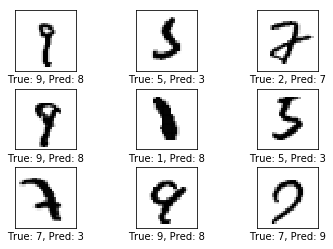

In [50]:
plot_example_errors(cls_pred)

## 总结

这份教程展示了如何通过贝叶斯优化神经网络的超参数。我们用scikit-optimize的（`skopt`）库，它任然在发展，但它已经是一个非常强大的工具。它能够在少量的迭代中显著地改进手工调优的超参数。这远远优于网格搜索和随机搜索，它们需要花费更多的计算时间，并且最有可能发现较差的超参数，特别是对于更困难的问题。

## 练习

下面使一些可能会让你提升TensorFlow技能的一些建议练习。为了学习如何更合适地使用TensorFlow，实践经验是很重要的。

在你对这个Notebook进行修改之前，可能需要先备份一下。

* 尝试运行100或200次迭代，而不是40次迭代。绘制的landscapes会发生什么变化？
* 尝试scikit-optimize中其他的优化方法，例如用`forest_minimize`来代替`gp_minimize`。它们的表现怎么样？
* 尝试给优化器用另一个采样函数，例如 Probability of Improvement。
* 尝试贝叶斯优化来优化更多的超参数。比如，在卷积层中卷积核的尺寸，滤波器的个数，或者是训练时的批大小。
* 加入卷积层数目的超参数，并且应用到`create_model()`函数中。注意，如果你在卷积层之后有池化层，图片会被下采样，所以需要限制卷积层的数目，防止图像变的太小。
* 看绘制的图。你是否认为某些超参数可能是无关紧要的？尝试移除这些参数，重做剩余超参数的优化。
* 用另一个更复杂的图像数据集文件
* 训练多更代（epochs）。验证集和测试集的分类准确率是否有提高？对时间效率有什么影响？
* 向朋友解释程序如何工作。

## License (MIT)

Copyright (c) 2016-2018 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.